In [1]:
import csv
import datetime
import h5py
import itertools
import keras
import numpy as np
import os
import pandas as pd
import pescador
import random
import sys
import tensorflow as tf
import time

sys.path.append("../src")
import localmodule


def multiplex_logmelspec(aug_kind_str, fold_units, n_hops, k, lam, batch_size):
    # Parse augmentation kind string (aug_kind_str).
    if aug_kind_str == "none":
        augs = ["original"]
    elif aug_kind_str == "pitch":
        augs == ["original", "pitch"]
    elif aug_kind_str == "stretch":
        augs == ["original", "stretch"]
    else:
        noise_augs = ["noise-" + unit_str for unit_str in fold_units]
        if aug_kind_str == "all":
            augs = noise_augs + ["original", "pitch", "stretch"]
        elif aug_kind_str == "noise":
            augs = noise_augs + ["original"]

    # Generate a Pescador streamer for every HDF5 container, that is,
    # every unit-augmentation-instance triplet.
    aug_dict = localmodule.get_augmentations()
    data_dir = localmodule.get_data_dir()
    dataset_name = localmodule.get_dataset_name()
    logmelspec_name = "_".join([dataset_name, "logmelspec"])
    logmelspec_dir = os.path.join(data_dir, logmelspec_name)
    streams = []
    for aug_str in augs:
        aug_dir = os.path.join(logmelspec_dir, aug_str)
        if aug_str == "original":
            instances = [aug_str]
        else:
            n_instances = aug_dict[aug_str]
            instances = ["-".join([aug_str, str(instance_id)])
                for instance_id in range(n_instances)]
        for instanced_aug_str in instances:
            for unit_str in fold_units:
                lms_name = "_".join([dataset_name, instanced_aug_str, unit_str])
                lms_path = os.path.join(aug_dir, lms_name + ".hdf5")
                stream = pescador.Streamer(yield_logmelspec, lms_path, n_hops)
                streams.append(stream)

    # Multiplex streamers together.
    mux = pescador.Mux(streams,
        k=k, lam=lam, with_replacement=True, revive=True)

    # Create buffered streamer with specified batch size.
    buffered_streamer = pescador.BufferedStreamer(mux, batch_size)

    return buffered_streamer.tuples("X", "y", cycle=True)


def yield_logmelspec(lms_path, n_hops):
    # Open HDF5 container.
    with h5py.File(lms_path, "r") as lms_container:
        # Open HDF5 group corresponding to log-mel-spectrograms (lms).
        lms_group = lms_container["logmelspec"]

        # The naming convention of a key is
        # [unit]_[time]_[freq]_[y]_[aug]_[instance]
        # where y=1 if the key corresponds to a positive clip and 0 otherwise.
        keys = list(lms_group.keys())
        keys = [keys[0], keys[5520]]
        while True:
            # Pick a key uniformly as random.
            key = random.choice(keys)

            # Load logmelspec.
            X = lms_group[key]

            # Trim logmelspec in time to required number of hops.
            X_width = X.shape[1]
            first_col = int((X_width-n_hops) / 2)
            last_col = int((X_width+n_hops) / 2)
            X = X[:, first_col:last_col]

            # Add trailing singleton dimension for Keras interoperability.
            X = X[:, :, np.newaxis]

            # Retrieve label y from key name.
            y = np.array([np.float32(key.split("_")[3])])

            # Yield data and label as dictionary.
            yield {"X": X, "y": y}


# Define constants.
dataset_name = localmodule.get_dataset_name()
folds = localmodule.fold_units()
models_dir = localmodule.get_models_dir()
n_input_hops = 104
n_filters = [24, 48, 48]
kernel_size = [5, 5]
pool_size = [2, 4]
n_hidden_units = 64
steps_per_epoch = 16
epochs = 1
validation_steps = 1
k = 2048
lam = 8.0
batch_size = 1


# Read command-line arguments.
args = ["none", "unit01", "trial-9"]
aug_kind_str = args[0]
unit_str = args[1]
trial_str = args[2]


# Retrieve fold such that unit_str is in the test set.
fold = [f for f in folds if unit_str in f[0]][0]
test_units = ["unit01"]
training_units = ["unit01"]
validation_units = ["unit01"]


# Print header.
start_time = int(time.time())
print(str(datetime.datetime.now()) + " Start.")
print("Training Salamon's ICASSP 2017 convnet on " + dataset_name + ". ")
print("Training set: " + ", ".join(training_units) + ".")
print("Validation set: " + ", ".join(validation_units) + ".")
print("Test set: " + ", ".join(test_units) + ".")
print("")
print('h5py version: {:s}'.format(h5py.__version__))
print('keras version: {:s}'.format(keras.__version__))
print('numpy version: {:s}'.format(np.__version__))
print('pandas version: {:s}'.format(pd.__version__))
print('pescador version: {:s}'.format(pescador.__version__))
print('tensorflow version: {:s}'.format(tf.__version__))
print("")


# Define and compile Keras model.
# NB: the original implementation of Justin Salamon in ICASSP 2017 relies on
# glorot_uniform initialization for all layers, and the optimizer is a
# stochastic gradient descent (SGD) with a fixed learning rate of 0.1.
# Instead, we use a he_uniform initialization for the layers followed
# by rectified linear units (see He ICCV 2015), and replace the SGD by
# the Adam adaptive stochastic optimizer (see Kingma ICLR 2014).
model = keras.models.Sequential()

# Layer 1
bn = keras.layers.normalization.BatchNormalization(
    input_shape=(128, n_input_hops, 1))
model.add(bn)
conv1 = keras.layers.Convolution2D(n_filters[0], kernel_size,
    padding="same", kernel_initializer="he_normal", activation="relu")
model.add(conv1)
pool1 = keras.layers.MaxPooling2D(pool_size=pool_size)
model.add(pool1)

# Layer 2
conv2 = keras.layers.Convolution2D(n_filters[1], kernel_size,
    padding="same", kernel_initializer="he_normal", activation="relu")
model.add(conv2)
pool2 = keras.layers.MaxPooling2D(pool_size=pool_size)
model.add(pool2)

# Layer 3
conv3 = keras.layers.Convolution2D(n_filters[2], kernel_size,
    padding="same", kernel_initializer="he_normal", activation="relu")
model.add(conv3)

# Layer 4
drop1 = keras.layers.Dropout(0.5)
model.add(drop1)
flatten = keras.layers.Flatten()
model.add(flatten)
dense1 = keras.layers.Dense(n_hidden_units,
    kernel_initializer="he_normal", activation="relu",
    kernel_regularizer=keras.regularizers.l2(0.01))
model.add(dense1)

# Layer 5
# We put a single output instead of 43 in the original paper, because this
# is binary classification instead of multilabel classification.
drop2 = keras.layers.Dropout(0.5)
model.add(drop2)
dense2 = keras.layers.Dense(1,
    kernel_initializer="normal", activation="sigmoid",
    kernel_regularizer=keras.regularizers.l2(0.0002))
model.add(dense2)


# Build Pescador streamers corresponding to log-mel-spectrograms in augmented
# training and validation sets.
training_streamer = multiplex_logmelspec(
    aug_kind_str, training_units, n_input_hops, k, lam, batch_size)
validation_streamer = multiplex_logmelspec(
    aug_kind_str, validation_units, n_input_hops, k, lam, batch_size)


# Create directory for model, unit, and trial.
model_name = "icassp-convnet"
if not aug_kind_str == "none":
    model_name = "_".join([model_name, "aug-" + aug_kind_str])
model_dir = os.path.join(models_dir, model_name)
os.makedirs(model_dir, exist_ok=True)
unit_dir = os.path.join(model_dir, unit_str)
os.makedirs(unit_dir, exist_ok=True)
trial_dir = os.path.join(unit_dir, trial_str)
os.makedirs(trial_dir, exist_ok=True)


# Create Keras callback for checkpointing model.
network_name = "_".join(
    [dataset_name, model_name, unit_str, trial_str, "network"])
network_path = os.path.join(trial_dir, network_name + ".hdf5")
checkpoint = keras.callbacks.ModelCheckpoint(network_path,
    monitor="val_loss", verbose=False, save_best_only=True, mode="min")


# Create custom callback for saving history.
history_name = "_".join(
    [dataset_name, model_name, unit_str, trial_str, "history"])
history_path = os.path.join(trial_dir, history_name + ".csv")
with open(history_path, 'w') as csv_file:
    csv_writer = csv.writer(csv_file)
    header = ['Epoch', 'Local time', 'Training loss', 'Training accuracy (%)',
        'Validation loss', 'Validation accuracy (%)']
    csv_writer.writerow(header)
def write_row(history_path, epoch, logs):
    with open(history_path, 'a') as csv_file:
        csv_writer = csv.writer(csv_file)
        row = [
            str(epoch).zfill(3),
            str(datetime.datetime.now()),
            "{:.16f}".format(logs.get('loss')),
            "{:.3f}".format(100*logs.get('acc')),
            "{:.16f}".format(logs.get('val_loss')),
            "{:.3f}".format(100*logs.get('val_acc'))]
        csv_writer.writerow(row)
history_callback = keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch, logs: write_row(history_path, epoch, logs))


# Export network architecture as YAML file.
yaml_path = os.path.join(trial_dir, network_name + ".yaml")
with open(yaml_path, "w") as yaml_file:
    yaml_string = model.to_yaml()
    yaml_file.write(yaml_string)
    
    
print(str(datetime.datetime.now()) + " Finish.")

Using TensorFlow backend.


2017-08-16 18:02:39.176234 Start.
Training Salamon's ICASSP 2017 convnet on BirdVox-70k. 
Training set: unit01.
Validation set: unit01.
Test set: unit01.

h5py version: 2.6.0
keras version: 2.0.6
numpy version: 1.13.1
pandas version: 0.20.3
pescador version: 1.0.0
tensorflow version: 1.2.1

2017-08-16 18:02:39.418929 Finish.


In [3]:
# Compile model, print model summary.
metrics = ["accuracy"]
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=metrics)
model.summary()


# Train model.
fold_units = ["unit01"]
augs = ["original"]
aug_dict = localmodule.get_augmentations()
data_dir = localmodule.get_data_dir()
dataset_name = localmodule.get_dataset_name()
logmelspec_name = "_".join([dataset_name, "logmelspec"])
logmelspec_dir = os.path.join(data_dir, logmelspec_name)
n_hops = 104

lms_paths = []
for aug_str in augs:
    aug_dir = os.path.join(logmelspec_dir, aug_str)
    if aug_str == "original":
        instances = [aug_str]
    else:
        n_instances = aug_dict[aug_str]
        instances = ["-".join([aug_str, str(instance_id)])
            for instance_id in range(n_instances)]
    for instanced_aug_str in instances:
        for unit_str in fold_units:
            lms_name = "_".join([dataset_name, instanced_aug_str, unit_str])
            lms_path = os.path.join(aug_dir, lms_name + ".hdf5")
            lms_paths.append(lms_path)

lms_path = random.choice(lms_paths)
lms_container = h5py.File(lms_path)
lms_group = lms_container["logmelspec"]
keys = list(lms_group.keys())
keys = [keys[0], keys[5520]]

# Trim logmelspec in time to required number of hops.
Xs = []
for key in keys:
    X = lms_group[key]
    X_width = X.shape[1]
    first_col = int((X_width-n_hops) / 2)
    last_col = int((X_width+n_hops) / 2)
    X = X[:, first_col:last_col]
    X = np.array(X)[np.newaxis, :, :, np.newaxis]
    X = (X + 20.0) / 6.5
    Xs.append(X)
X = np.concatenate(Xs, axis=0)
y = np.array([0.0, 1.0]).astype('float32')

model.fit(X[:,:,:,:], y[:], epochs=50)
#history = model.fit_generator(
#   training_streamer,
#    steps_per_epoch = 64,
#    epochs = 1,
#    verbose = True,
#    callbacks = [checkpoint, history_callback],
#    validation_data = validation_streamer,
#    validation_steps = 1)


# Print history.
#history_df = pd.DataFrame(history.history)
#print(history_df.to_string())
#print("")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2 (Batch (None, 128, 104, 1)       4         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 104, 24)      624       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 26, 24)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 26, 48)        28848     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 6, 48)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 6, 48)         57648     
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 6, 48)         0         
__________

unit01_927530255_03529_1_original
[[ 0.]]


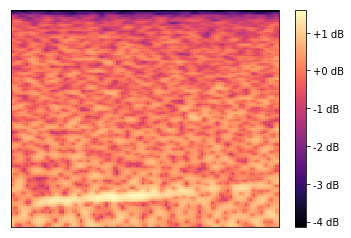

In [13]:
import random

fold_units = ["unit01"]
augs = ["original"]
aug_dict = localmodule.get_augmentations()
data_dir = localmodule.get_data_dir()
dataset_name = localmodule.get_dataset_name()
logmelspec_name = "_".join([dataset_name, "logmelspec"])
logmelspec_dir = os.path.join(data_dir, logmelspec_name)
n_hops = 104

lms_paths = []
for aug_str in augs:
    aug_dir = os.path.join(logmelspec_dir, aug_str)
    if aug_str == "original":
        instances = [aug_str]
    else:
        n_instances = aug_dict[aug_str]
        instances = ["-".join([aug_str, str(instance_id)])
            for instance_id in range(n_instances)]
    for instanced_aug_str in instances:
        for unit_str in fold_units:
            lms_name = "_".join([dataset_name, instanced_aug_str, unit_str])
            lms_path = os.path.join(aug_dir, lms_name + ".hdf5")
            lms_paths.append(lms_path)

lms_path = random.choice(lms_paths)
lms_container = h5py.File(lms_path)
lms_group = lms_container["logmelspec"]
keys = list(lms_group.keys())
keys = [keys[0], keys[5520]]
# Pick a key uniformly as random.
key = random.choice(keys)

# Load logmelspec.
X = lms_group[key]

# Trim logmelspec in time to required number of hops.
X_width = X.shape[1]
first_col = int((X_width-n_hops) / 2)
last_col = int((X_width+n_hops) / 2)
X = X[:, first_col:last_col]
X = np.array(X)[np.newaxis, :, :, np.newaxis]
X = (X + 20.0) / 6.5

from matplotlib import pyplot as plt
import librosa.display
%matplotlib inline
librosa.display.specshow(np.squeeze(X), cmap="magma")
plt.colorbar(format='%+2.0f dB')
print(key)

print(model.predict(X))

In [22]:
tmp = next(training_streamer)
x = tmp[0][:, 0,0,0]
y = tmp[1]
print(x)
print(y.T)

[ 1.43750262]
[[ 1.]]


In [2]:
X.shape

NameError: name 'X' is not defined